<a href="https://colab.research.google.com/github/tekliyetamiru/Fake-News-Detections-By-Using-DistilBERT-MobileBERT-and-TinyBERT-Model/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine Tuning DistilBERT, MobileBERT and TinyBERT for Fake News Detection**

In [ ]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U Umap-learn
# !pip install seaborn --upgrade

# !pip install -U openpyxl

# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')


## **Data Loading**

In [40]:
import pandas as pd

datafile = pd.read_excel("https://github.com/tekliyetamiru/Fake-News-Detections-By-Using-DistilBERT-MobileBERT-and-TinyBERT-Model/raw/main/fake_news.xlsx")
datafile.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [41]:
datafile.isnull().sum()

,0
id,0
title,558
author,1957
text,43
label,0


In [42]:
datafile = datafile.dropna()
datafile.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [43]:
datafile['label'].value_counts()

,count
label,
0,10361
1,7920


## **Dataset Analysis**

In [44]:
import matplotlib.pyplot as plt


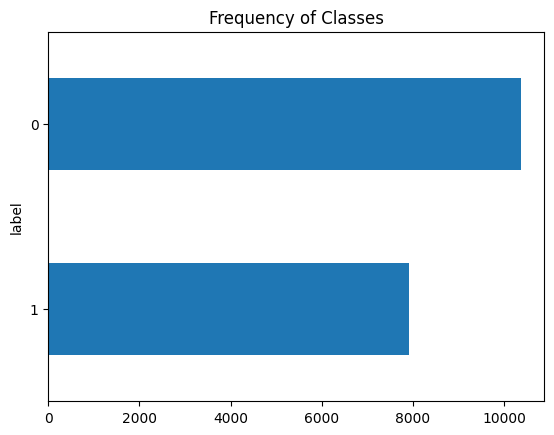

In [45]:
label_counts = datafile['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

Text(0.5, 1.0, 'Text Tokens')

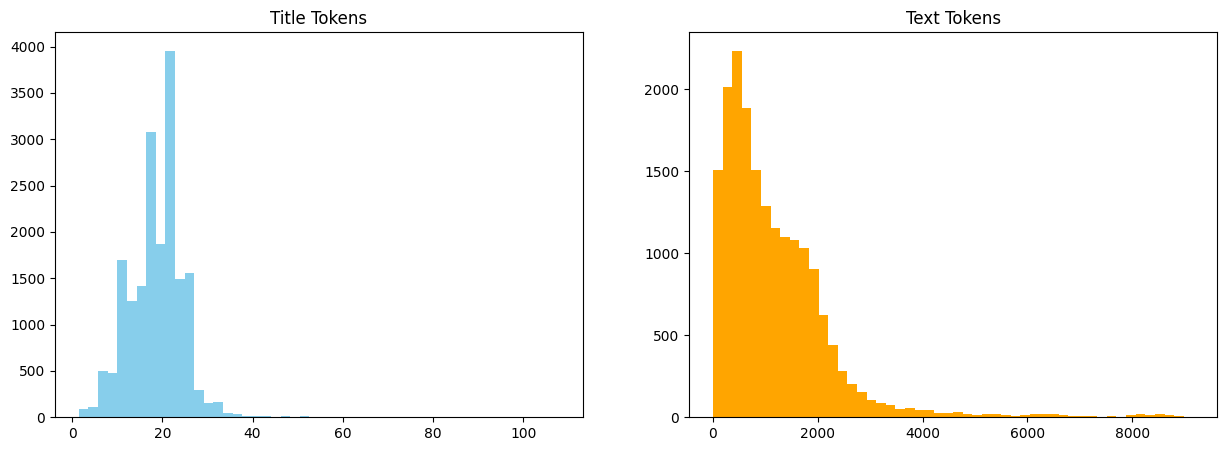

In [46]:
# 1.5 tokens per word on average

datafile['title_tokens'] = datafile['title'].apply(lambda x: len(x.split())*1.5)
datafile['text_tokens'] = datafile['text'].apply(lambda x: len(x.split())*1.5)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(datafile['title_tokens'], bins=50, color="skyblue")
ax[0].set_title("Title Tokens")

ax[1].hist(datafile['text_tokens'], bins=50, color="orange")
ax[1].set_title("Text Tokens")


### **Split Dataset into train and test**

In [47]:
from sklearn.model_selection import train_test_split

# 70% for traing, 20% for test and 10% for validation
train, test = train_test_split(datafile, test_size = 0.3, stratify=datafile['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

datafile.shape,train.shape, test.shape, validation.shape

((18281, 7), (12796, 7), (3656, 7), (1829, 7))

In [48]:
from datasets import Dataset, DatasetDict

dataset= DatasetDict({
    "train":Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation":Dataset.from_pandas(validation, preserve_index=False)
})

In [50]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

### **Data Tokenization**

In [49]:
from transformers import AutoTokenizer
text = "machine learning is awesome!! Thanks KG take."

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)

In [51]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=100

In [52]:
def tokenize(batch):
  temp = distilbert_tokenizer(batch['title'],padding=True, truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 6221, 8398, 22577, 4769, 28667, 9331, 102], [101, 2006, 1996, 2769, 4446, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0]]}


In [53]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## **Model Building**

In [54]:
from transformers import AutoModelForSequenceClassification,AutoConfig
import torch

label2id = {"Real":0,"Fake":1}
id2label = {0:"Real",1:"Fake"}


model_ckpt = "distilbert-base-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
# model_ckpt = "google/mobilebert-uncased"

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.6",
  "vocab_size": 30522
}

## **Model Training**

In [56]:
!pip install evaluate

In [60]:
# Build compute metrics function
# !pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions,references=labels)

In [59]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False
)

In [61]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,

In [63]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenizer
)

In [64]:
trainer.train()

Step,Training Loss
500,0.247900
1000,0.165900
1500,0.145400
2000,0.093500
2500,0.099500
3000,0.071300
3500,0.058800
4000,0.029700
4500,0.026300


TrainOutput(global_step=4800, training_loss=0.09948440988858541, metrics={'train_runtime': 504.7821, 'train_samples_per_second': 76.049, 'train_steps_per_second': 9.509, 'total_flos': 953467218676224.0, 'train_loss': 0.09948440988858541, 'epoch': 3.0})

## **Model Evaluation**

In [70]:
preds_output=trainer.predict(encoded_dataset['test'])

In [71]:
preds_output.metrics

{'test_loss': 0.20663656294345856,
 'test_accuracy': 0.9600656455142232,
 'test_runtime': 8.6635,
 'test_samples_per_second': 421.999,
 'test_steps_per_second': 52.75}

In [72]:
y_pred = np.argmax(preds_output.predictions,axis=1)
y_true = encoded_dataset['test'][:]['label']

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.97      0.95      0.96      2072
        Fake       0.94      0.97      0.95      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## **Benchmarking**

In [74]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels,preds,average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy":acc, "f1":f1}

In [75]:

model_dict={
    "bert-base":"bert-base-uncased",
    "distilbert":"distilbert-base-uncased",
    "mobilebert":"google/mobilebert-uncased",
    "tinybert":"huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
  model_ckpt=model_dict[model_name]
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id, id2label=id2label)
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

  def local_tokenizer(batch):
    temp = tokenizer(batch['title'],padding=True,truncation=True)
    return temp

  encoded_dataset=dataset.map(local_tokenizer,batched=True,batch_size=None)

  trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer
    )
  trainer.train()

  preds = trainer.predict(encoded_dataset['test'])

  return preds.metrics

import time
model_performance={}
for model_name in model_dict:
  print("\n\n")
  print("Training Model: ", model_name)

  start = time.time()
  result = train_model(model_name)
  end = time.time()
  model_performance[model_name] = {model_name:result,"time taken":end-start}




Training Model:  bert-base


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.271100
1000,0.193100
1500,0.165800
2000,0.099100
2500,0.083900
3000,0.089800
3500,0.062600
4000,0.028500
4500,0.021400





Training Model:  distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.247900
1000,0.165900
1500,0.145400
2000,0.093500
2500,0.099500
3000,0.071300
3500,0.058800
4000,0.029700
4500,0.026300





Training Model:  mobilebert


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,46425.256000
1000,0.473600
1500,0.159000
2000,0.431700
2500,0.865000
3000,0.124000
3500,0.072600
4000,0.048200
4500,0.049000





Training Model:  tinybert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.321300
1000,0.233400
1500,0.180700
2000,0.155600
2500,0.146500
3000,0.132400
3500,0.121200
4000,0.090700
4500,0.078600


In [76]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.21569882333278656,
   'test_accuracy': 0.9641684901531729,
   'test_f1': 0.9642023962711367,
   'test_runtime': 16.2377,
   'test_samples_per_second': 225.156,
   'test_steps_per_second': 28.144},
  'time taken': 1030.1525733470917},
 'distilbert': {'distilbert': {'test_loss': 0.20663656294345856,
   'test_accuracy': 0.9600656455142232,
   'test_f1': 0.9601224562127675,
   'test_runtime': 8.4189,
   'test_samples_per_second': 434.261,
   'test_steps_per_second': 54.283},
  'time taken': 511.39694595336914},
 'mobilebert': {'mobilebert': {'test_loss': 0.23570948839187622,
   'test_accuracy': 0.9617067833698031,
   'test_f1': 0.9617207157520139,
   'test_runtime': 19.9964,
   'test_samples_per_second': 182.833,
   'test_steps_per_second': 22.854},
  'time taken': 887.5792484283447},
 'tinybert': {'tinybert': {'test_loss': 0.21589840948581696,
   'test_accuracy': 0.9584245076586433,
   'test_f1': 0.9584541066069543,
   'test_runtime': 2.9968,
  

In [84]:

import json

# 1. Load the notebook file
filename = '/content/drive/MyDrive/Colab Notebooks/Fake News Detection.ipynb'
with open(filename, 'r') as f:
    data = json.load(f)

# 2. Remove the 'widgets' entry from metadata if it exists
if 'widgets' in data.get('metadata', {}):
    del data['metadata']['widgets']
    print("Metadata 'widgets' key removed successfully.")

# 3. Overwrite the file with the clean version
with open(filename, 'w') as f:
    json.dump(data, f, indent=1)